## Amazon Alexa Reviews Analysis

### [Dataset link](https://www.kaggle.com/sid321axn/amazon-alexa-reviews)

* The project analyzes reviews by users of **Amazon’s Alexa products**. 


* The primary methods used are **Random Forrest and Gradient Boosting** for this dataset. 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_palette("bright")

### Importing Data

In [4]:
data = pd.read_csv("../input/amazon_alexa.tsv", sep="\t")

In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


<br>
### Exploring the dataset 
This data set has five columns:
* rating
* date
* variation
* verfied_reviews
* feedback

We will explore each column with the help of charts and how does it impact our target column **feedback**.

In [6]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

Rating column has values:

In [7]:
data['rating'].unique()

array([5, 4, 3, 2, 1])

#### Converting *date* attribute from string to datetime.date datatype
We will be using date column for feature engineering, so it would be a good idea if we convert this column from a **string** datatype to a **datetime.date** datatype.

In [8]:
type(data['date'][0]) , data['date'][0]

(str, '31-Jul-18')

In [9]:
data['date'] = pd.to_datetime(data['date'])
data['date'][0]

Timestamp('2018-07-31 00:00:00')

In [10]:
dates = data['date']
only_dates = []
for date in dates:
    only_dates.append(date.date())

data['only_dates'] = only_dates
data['only_dates'][0]

datetime.date(2018, 7, 31)

### Feature Engineering:

#### Extracting *Year, Month, Day of the Week* from date.
* We will be using these features later in the model.
* We will extract month, year and day of the week into separate columns.

In [11]:
only_year = []
for date in dates:
    only_year.append(date.year)
data['year'] = only_year


only_month = []
for date in dates:
    only_month.append(date.month)
data['month'] = only_month

# 1 -> monday
# 7 -> sunday
only_weekday = []
for date in dates:
    only_weekday.append(date.isoweekday())
data['day_of_week'] = only_weekday

#### Estimating length of the reviews 
* Calculating the length of text proves to be an important feature for classifying text in a Natural Language Processing problem.

In [12]:
reviews = data['verified_reviews']
len_review = []
for review in reviews:
    len_review.append(len(review))

data['len_of_reviews'] = len_review

In [13]:
data['len_of_reviews'][0], data['verified_reviews'][0]

(13, 'Love my Echo!')

#### Updated Column List:
* As a result, we have added new columns in our dataset.

In [14]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback',
       'only_dates', 'year', 'month', 'day_of_week', 'len_of_reviews'],
      dtype='object')

### Visualizing your Exploratory Data Analysis:

* With the help of this graph we can detect that the number of 5 rating review is high in this dataset. <br>
* In other words it seems that customers are very much happy with Alexa products.

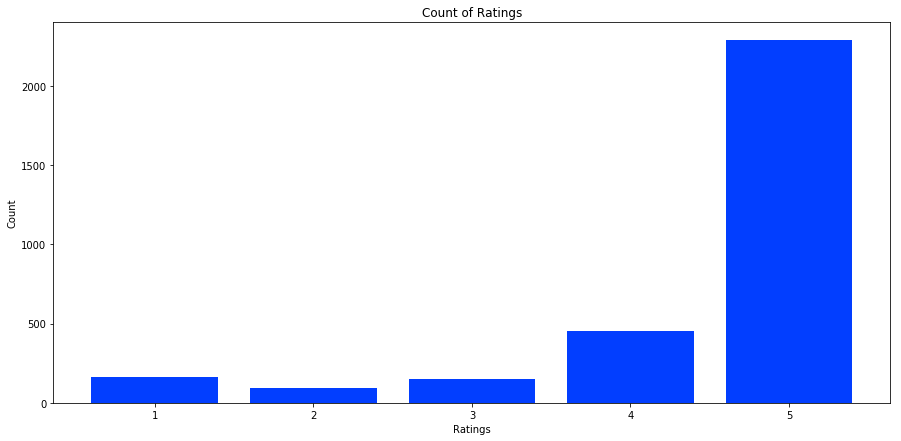

In [15]:
plt.figure(figsize=(15,7))
plt.bar(height = data.groupby('rating').count()['date'], x = sorted(data['rating'].unique(), reverse= False))
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Count of Ratings")
plt.show()

* On applying a hue of feedback, we can detect that reviews which have a rating of more than 2, result in a positive feedback (1). 
* We will be removing this column from the training set, we would prefer the learning algorithm not to capitalize on this feature.

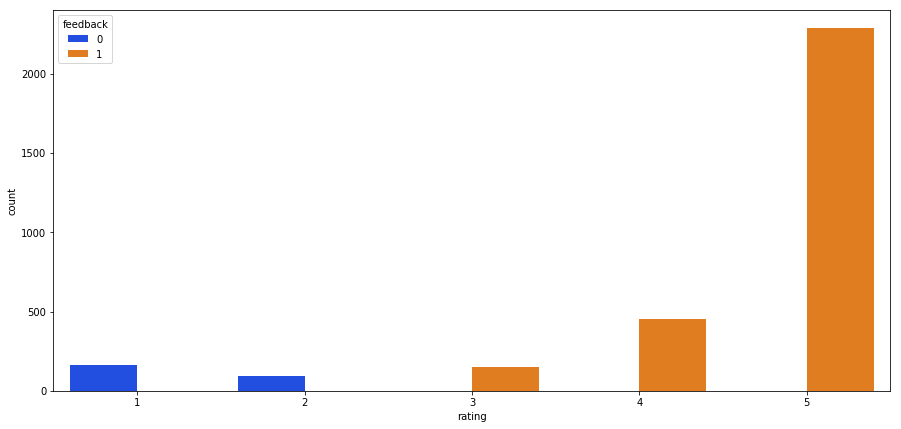

In [16]:
plt.figure(figsize=(15,7))
sns.countplot(x="rating", hue="feedback", data=data)
plt.show()

* The bar plot of rating with respect to variation highlights that black dot is the most frequently ordered product and also most liked.

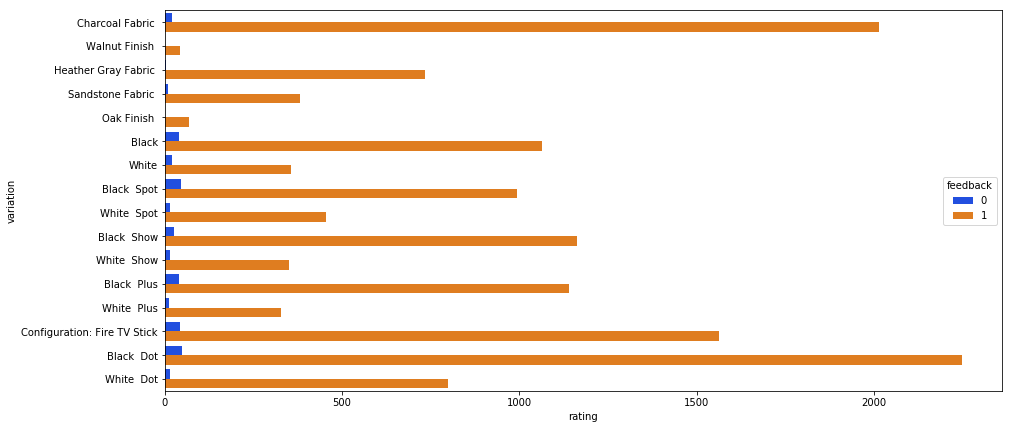

In [17]:
plt.figure(figsize=(15,7))
sns.barplot(x="rating", y="variation", hue="feedback", data=data, estimator= sum, ci = None)
plt.show()

* On changing the aggregation function to mean(default), average rating seems to be 4.5 for every positive feedback review.

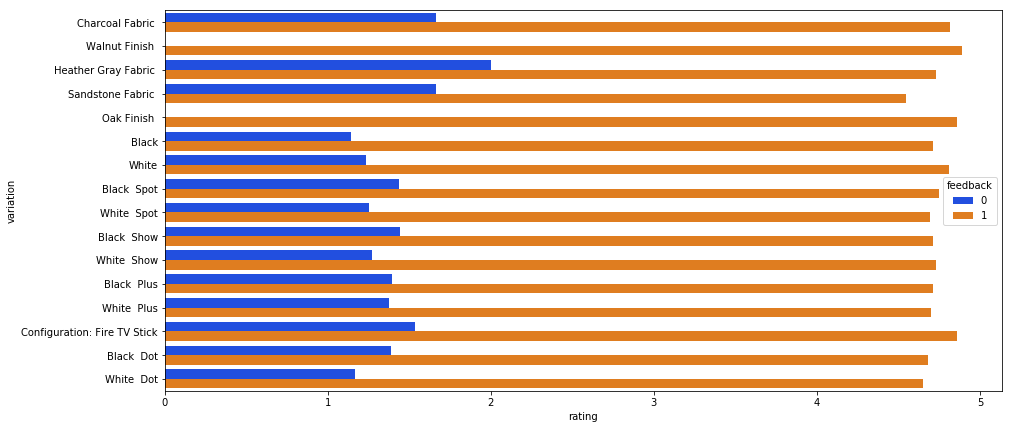

In [18]:
plt.figure(figsize=(15,7))
sns.barplot(x="rating", y="variation", hue="feedback", data=data, ci = None)
plt.show()

* When we take month into consideration, most orders in this dataset comes from the month of July.

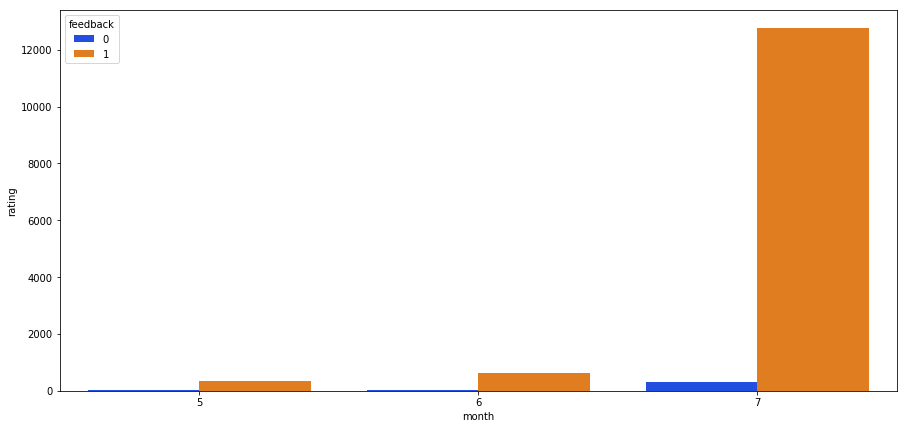

In [19]:
plt.figure(figsize=(15,7))
sns.barplot(y="rating", x="month", hue="feedback", data=data, ci = None, estimator= sum)
plt.show()

* Changing the average function to mean again does not highlight anything important, just the fact that the products have high ratings.

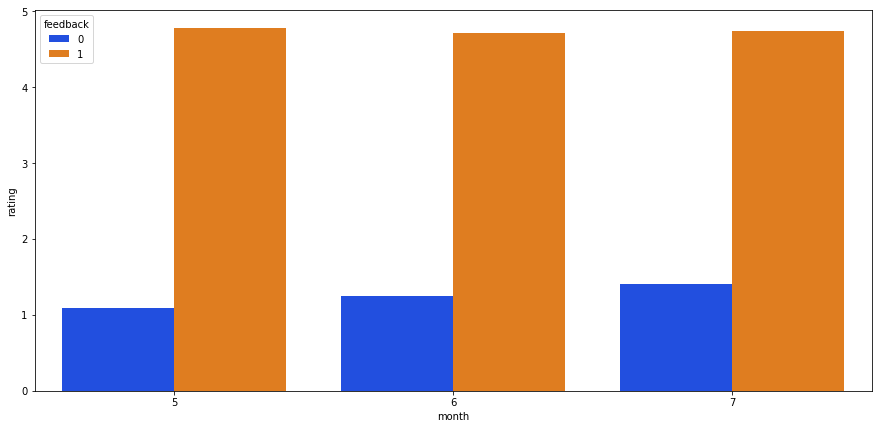

In [20]:
plt.figure(figsize=(15,7))
sns.barplot(y="rating", x="month", hue="feedback", data=data, ci = None)
plt.show()

* When day of the week is considered, it seems that Monday happens to be the day when most people write their reviews.
* This can relate to prime delivery guarantee within two days, and the most frequent day of ordering being on Saturday or the weekend.

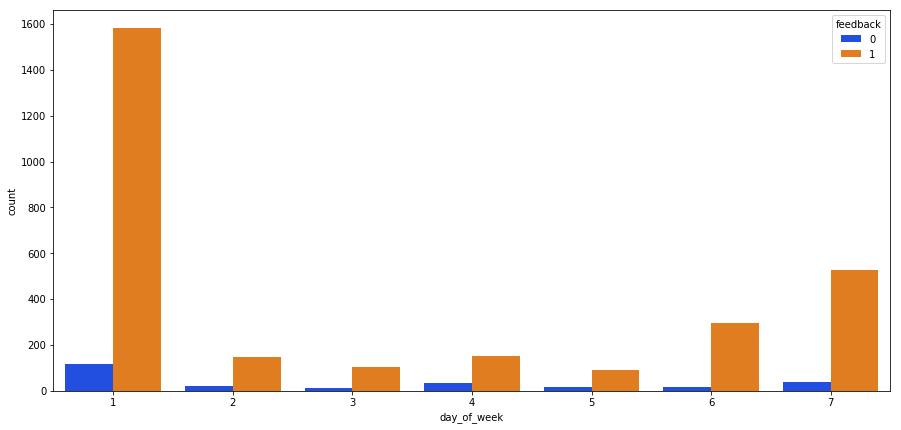

In [21]:
plt.figure(figsize=(15,7))
sns.countplot(x="day_of_week", hue="feedback", data=data)
plt.show()

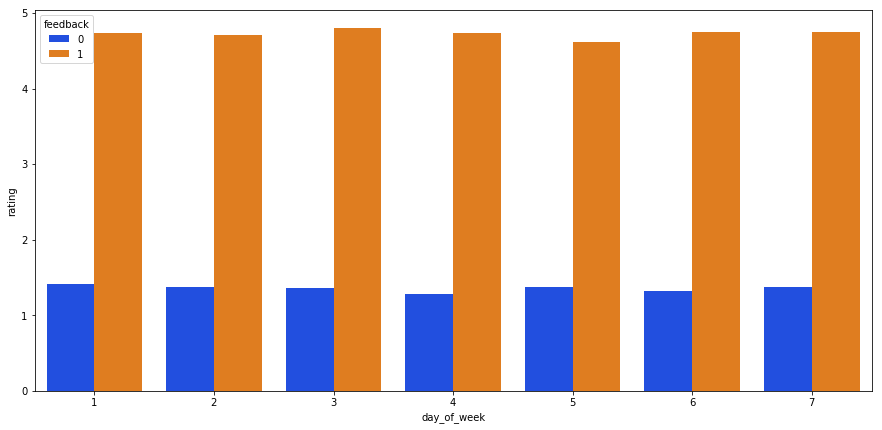

In [22]:
plt.figure(figsize=(15,7))
sns.barplot(y="rating", x="day_of_week", hue="feedback", data=data, ci = None)
plt.show()

* Overall this dataset is imbalanced towards negative reviews.
* Therefore the important score to look at would be the **F1 Score**, on how the model performed.

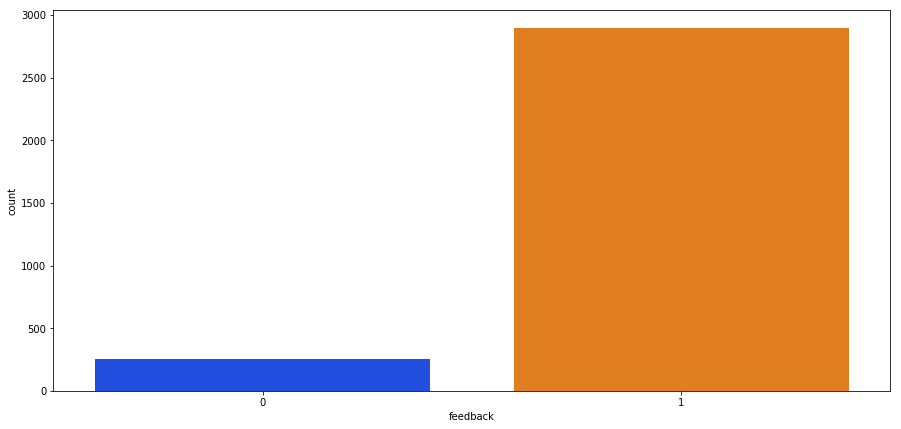

In [23]:
plt.figure(figsize=(15,7))
sns.countplot(x="feedback", data=data)
plt.show()

* Finally the length column, which depicts that customers with negative review tend to write a longer review.

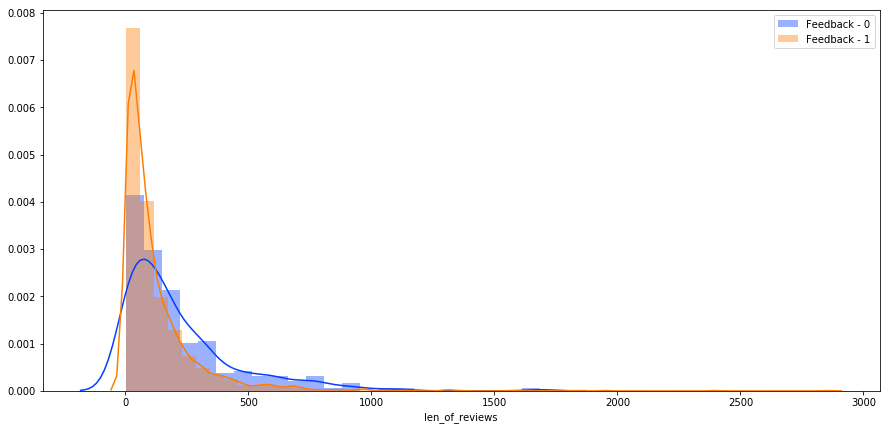

In [24]:
plt.figure(figsize=(15,7))
sns.distplot(data[data['feedback'] == 0]['len_of_reviews'], label = 'Feedback - 0')
sns.distplot(data[data['feedback'] == 1]['len_of_reviews'], label = 'Feedback - 1')
plt.legend()
plt.show()

### Data Preprocessing:

#### TfidfVectorizer:<br>

* Since we cannot directly insert text data into out machine learning models, we will have to use a vectorizer.
* The most vectorizer for any text data happens to be Count-Vectorizer, because it is easy to understand and relate to.
* We will use Term frequency inverse document frequency (TF-IDF) vectorizer for this dataset.
* The formula is as:
![tdf](https://skymind.ai/images/wiki/tfidf.png)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tdf = TfidfVectorizer(stop_words='english')

In [27]:
pd.DataFrame(tdf.fit_transform(data['verified_reviews']).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.294106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
tdf_data = pd.DataFrame(tdf.fit_transform(data['verified_reviews']).toarray())

### One Hot Encoding: <br>

* For variation we will be using one hot encoding, which can be expalined by the image below.

![ohe](https://i.imgur.com/mtimFxh.png)
<br>
* One important thing to take care about it no matter how many dummy variables you end up having, just make sure that drop any one variable.
* You can do this by setting **drop_first = True**.
* This problem is sometimes stated as dummy variable trap.

In [29]:
pd.get_dummies(data['variation'], drop_first= True)

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [30]:
one_hot_data = pd.get_dummies(data['variation'])

* Now, we can just concat all the features which we intend to use into a singe dataframe called **X**.

In [31]:
X = pd.concat([one_hot_data, tdf_data, data['month'], data['day_of_week'], data['len_of_reviews']], axis=1)

In [32]:
X.head()

,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783,month,day_of_week,len_of_reviews
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,13
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,9
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.294106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,195
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,172
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,5


* And the target vector **y**.

In [33]:
y = data['feedback']

### K Fold Cross Validation:
* K Fold cross validation gives a good idea on how is our selected model performing on different chunks of data.
* We are getting perfect scores through cross validation, as a result we would not be performing hyper parameter tuning.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

rf = RandomForestClassifier()

k_fold = KFold(n_splits=5)

cross_val_score(rf, X, y, cv=k_fold, scoring='accuracy')

array([0.93015873, 0.95396825, 0.8968254 , 0.9015873 , 0.94285714])

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Random Forest Classifier:

In [36]:
rf = RandomForestClassifier()
fit_model = rf.fit(X_train, y_train)

* One of the most important methods of random forest classifier in scikit learn is **feature_importances_**.
* Let us have a look at the top 10 features.

In [37]:
t = zip(fit_model.feature_importances_, X_train.columns)
t1 = reversed(sorted(t , key=lambda x: x[0]))
i = 0
for element in t1:
    if (i < 10):
        print(element)
        i = i + 1

(0.03725428298936584, 'len_of_reviews')
(0.021995940350486718, 'day_of_week')
(0.017843039918246144, 3736)
(0.016807028046442747, 3365)
(0.013598667887584454, 1528)
(0.012583382259739328, 3640)
(0.012390153269178736, 3222)
(0.011561698943543714, 1300)
(0.010379341087165097, 957)
(0.009824756105727682, 1047)


In [38]:
y_pred = rf.predict(X_test)


#### Learning Curve:

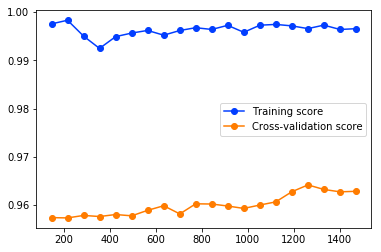

In [39]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, y_train, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 20), cv = 3)

train_scores = np.mean(train_scores, axis = 1)
test_scores = np.mean(test_scores, axis = 1)

plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Cross-validation score")
plt.legend();

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [41]:
print("==============================================")
print("For Random Forest Classifier:\n")
print("Accuracy Score: ",accuracy_score(y_test, y_pred))
print("Precision Score: ",precision_score(y_test, y_pred))
print("Recall Score: ",recall_score(y_test, y_pred))
print("F1 Score: ",f1_score(y_test, y_pred))
print("Confusion Matrix:\t \n",confusion_matrix(y_test, y_pred))

print("==============================================")

For Random Forest Classifier:

Accuracy Score:  0.9259259259259259
Precision Score:  0.9320388349514563
Recall Score:  0.9919632606199771
F1 Score:  0.9610678531701892
Confusion Matrix:	 
 [[ 11  63]
 [  7 864]]


#### Gradient Boosting Classifier: 

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("==============================================")
print("For Gradient Boosting Classifier:\n")
print("Accuracy Score: ",accuracy_score(y_test, y_pred))
print("Precision Score: ",precision_score(y_test, y_pred))
print("Recall Score: ",recall_score(y_test, y_pred))
print("F1 Score: ",f1_score(y_test, y_pred))
print("Confusion Matrix:\t \n",confusion_matrix(y_test, y_pred))
print("==============================================")

For Gradient Boosting Classifier:

Accuracy Score:  0.9259259259259259
Precision Score:  0.9320388349514563
Recall Score:  0.9919632606199771
F1 Score:  0.9610678531701892
Confusion Matrix:	 
 [[ 11  63]
 [  7 864]]


### Conclusions: 
* Feature Engineering is the most crucial step when it comes to Natural Language Processing. 
* Switching Count Vectorizer with a TDF IF Vectorizer also made a difference on F1 score. 


In [43]:
results = pd.DataFrame(data = {'Y Test': y_test, 'Y Predictions': y_pred})

In [44]:
results.head()

,Y Test,Y Predictions
2632,1,1
77,1,1
2522,1,1
1001,1,1
1721,1,1


In [45]:
results.to_csv('Results.csv')